# Experiment Notebook

In [1]:
# Run this cell as is:

import datetime
import json
import os 
import shutil
import sys
import uuid
import yaml

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

sys.path.append(os.path.join("..", "code"))
from cnn_dataset import CNNSeqDataset
from cnn_models import GAPTransArchitecture, GAPTransMaxArchitecture, ConvResizeGAPTransArchitecture
from utils import convert_datetime

pd.set_option("display.max_colwidth", 500)

DIR = os.getcwd()
DATA_DIR = os.path.join(os.path.dirname(DIR), "data")
EXPERIMENT_DIR = os.path.join(os.path.dirname(DIR), "experiments")
if not os.path.exists(EXPERIMENT_DIR):
    os.mkdir(EXPERIMENT_DIR)

## Experiment Parameters

#### Adjust these parameters for the desired experiment:

In [2]:
# Change the parameters here for the desired experiment settings:

PARAMETERS = dict(
    gages=['11402000', '11189500'],#] '11318500',]# '11266500', '11208000', '11202710', '11185500'],
    y_col="m3",
    n_days_precip=7,
    n_days_temp=7,
    n_days_et=8,
    swe_days_relative=[7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84],
    n_days_y=14,
    use_masks=True,
    shuffle_train=True,

    # Model architecture params:
    dem_kernal=(2, 2), dem_strides=(1, 1),
    et_kernal=(2, 2), et_strides=(1, 1),
    temp_kernal=(2, 2), temp_strides=(1, 1),
    precip_kernal=(2, 2), precip_strides=(1, 1),
    swe_kernal=(2, 2), swe_strides=(1, 1),
    enc_embed_dim=24, enc_dense_dim=48, enc_num_heads=4,
    dec_embed_dim=24, dec_dense_dim=48, dec_num_heads=4,
    hidden_dim=24, dropout=0.5, 
    pooling="avg",
    
    # CNN parameters for resizing models:
    cnn_activation="relu",
    kernal=(2, 2), strides=(1, 1),

    # Model training params:
    epochs=2,
    learning_rate=0.0001,
    opt=keras.optimizers.Adam,
    loss="mean_squared_error",
    tf_board_update_freq=100,
)

In [3]:
# Run this cell as is:

PARAMETERS["n_swe"] = len(list(PARAMETERS["swe_days_relative"]))
PARAMETERS["n_et"] = PARAMETERS["n_days_et"] // 8

experiment = dict()
experiment["start_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
experiment_id = str(uuid.uuid4())
print(f"experiment_id = '{experiment_id}'")
experiment["id"] = experiment_id
TF_LOG_DIR = os.path.join(EXPERIMENT_DIR, experiment_id)
if not os.path.exists(TF_LOG_DIR):
    os.mkdir(TF_LOG_DIR)
    
FEATURES = ("dem", "temp", "precip", "swe", "et")
TRAIN_DIR = os.path.join(DATA_DIR, "training_data") 
Y_FP = os.path.join(DATA_DIR, "streamgage-full.csv")
dates = {
    "train": {
        "start": "2010_01_01", 
        "end": "2014_12_31", 
    },
    "val": {
        "start": "2015_01_01", 
        "end": "2015_12_31", 
    },
    "test": {
        "start": "2016_01_01", 
        "end": "2016_12_31", 
    },
}
DATE_PARAMS = dict()
for k, v in dates.items():
    DATE_PARAMS[k] = dict()
    for k2, v2 in v.items():
        DATE_PARAMS[k][k2] = convert_datetime(v2)

experiment_id = 'd794a258-f6f2-4dbc-a1a8-b726e9047ae7'


## Create dataset instance

In [4]:
# Run this cell as is:
cnn_data = CNNSeqDataset(
    precip_dirs=[TRAIN_DIR],
    temp_dirs=[TRAIN_DIR],
    et_dirs=[TRAIN_DIR],
    swe_dirs=[TRAIN_DIR],
    y_fp=Y_FP,
    y_col=PARAMETERS["y_col"],
    n_d_precip=PARAMETERS["n_days_precip"],
    n_d_temp=PARAMETERS["n_days_temp"],
    n_d_et=PARAMETERS["n_days_et"],
    swe_d_rel=PARAMETERS["swe_days_relative"],  
    n_d_y=PARAMETERS["n_days_y"],
    min_date=DATE_PARAMS["train"]["start"],
    max_date=DATE_PARAMS["test"]["end"],
    val_start=DATE_PARAMS["val"]["start"],
    test_start=DATE_PARAMS["test"]["start"],
    use_masks=PARAMETERS["use_masks"],
    random_seed=42,
    shuffle_train=PARAMETERS["shuffle_train"],  
    gages=PARAMETERS["gages"], 
)

print(f"Num training examples = {len(cnn_data.train_pairs)}")

Calculating pixel mean/std from 2 images


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Num training examples = 3484


## Create the Model

In [ ]:
# Run this cell to use the GAPTransArchitecture:

experiment["architecture"] = "GAPTransArchitecture"

def get_gt_model():
    # Create the model architecture:
    architecture = GAPTransArchitecture()
    model = architecture.get_model(
        dem_kernal=PARAMETERS["dem_kernal"], dem_strides=PARAMETERS["dem_strides"],
        et_kernal=PARAMETERS["et_kernal"], et_strides=PARAMETERS["et_strides"],
        temp_kernal=PARAMETERS["temp_kernal"], temp_strides=PARAMETERS["temp_strides"],
        precip_kernal=PARAMETERS["precip_kernal"], precip_strides=PARAMETERS["precip_strides"],
        swe_kernal=PARAMETERS["swe_kernal"], swe_strides=PARAMETERS["swe_strides"],
        n_days_precip=PARAMETERS["n_days_precip"],  n_days_temp=PARAMETERS["n_days_temp"],
        n_swe=PARAMETERS["n_swe"], n_et=PARAMETERS["n_et"],
        enc_embed_dim=PARAMETERS["enc_embed_dim"], enc_dense_dim=PARAMETERS["enc_dense_dim"],
        enc_num_heads=PARAMETERS["enc_num_heads"],
        dec_embed_dim=PARAMETERS["dec_embed_dim"], dec_dense_dim=PARAMETERS["dec_dense_dim"],
        dec_num_heads=PARAMETERS["dec_num_heads"],
        n_y=PARAMETERS["n_days_y"], hidden_dim=PARAMETERS["hidden_dim"], 
        dropout=PARAMETERS["dropout"], 
        pooling=PARAMETERS["pooling"],
    )
    return model

model = get_gt_model()
keras.utils.plot_model(model, "gap_trans_model.png", show_shapes=True)

In [ ]:
# Run this cell to use the GAPTransMaxArchitecture:

experiment["architecture"] = "GAPTransMaxArchitecture"

def get_gtm_model():
    # Create the model architecture:
    architecture = GAPTransMaxArchitecture()
    model = architecture.get_model(
        kernal=PARAMETERS["kernal"], strides=PARAMETERS["strides"],
        n_days_precip=PARAMETERS["n_days_precip"],  n_days_temp=PARAMETERS["n_days_temp"],
        n_swe=PARAMETERS["n_swe"], n_et=PARAMETERS["n_et"],
        enc_embed_dim=PARAMETERS["enc_embed_dim"], enc_dense_dim=PARAMETERS["enc_dense_dim"],
        enc_num_heads=PARAMETERS["enc_num_heads"],
        dec_embed_dim=PARAMETERS["dec_embed_dim"], dec_dense_dim=PARAMETERS["dec_dense_dim"],
        dec_num_heads=PARAMETERS["dec_num_heads"],
        n_y=PARAMETERS["n_days_y"], hidden_dim=PARAMETERS["hidden_dim"], 
        dropout=PARAMETERS["dropout"],
        cnn_activation=PARAMETERS["cnn_activation"]
    )
    return model

model = get_gtm_model()
keras.utils.plot_model(model, "gap_trans_max_model.png", show_shapes=True)

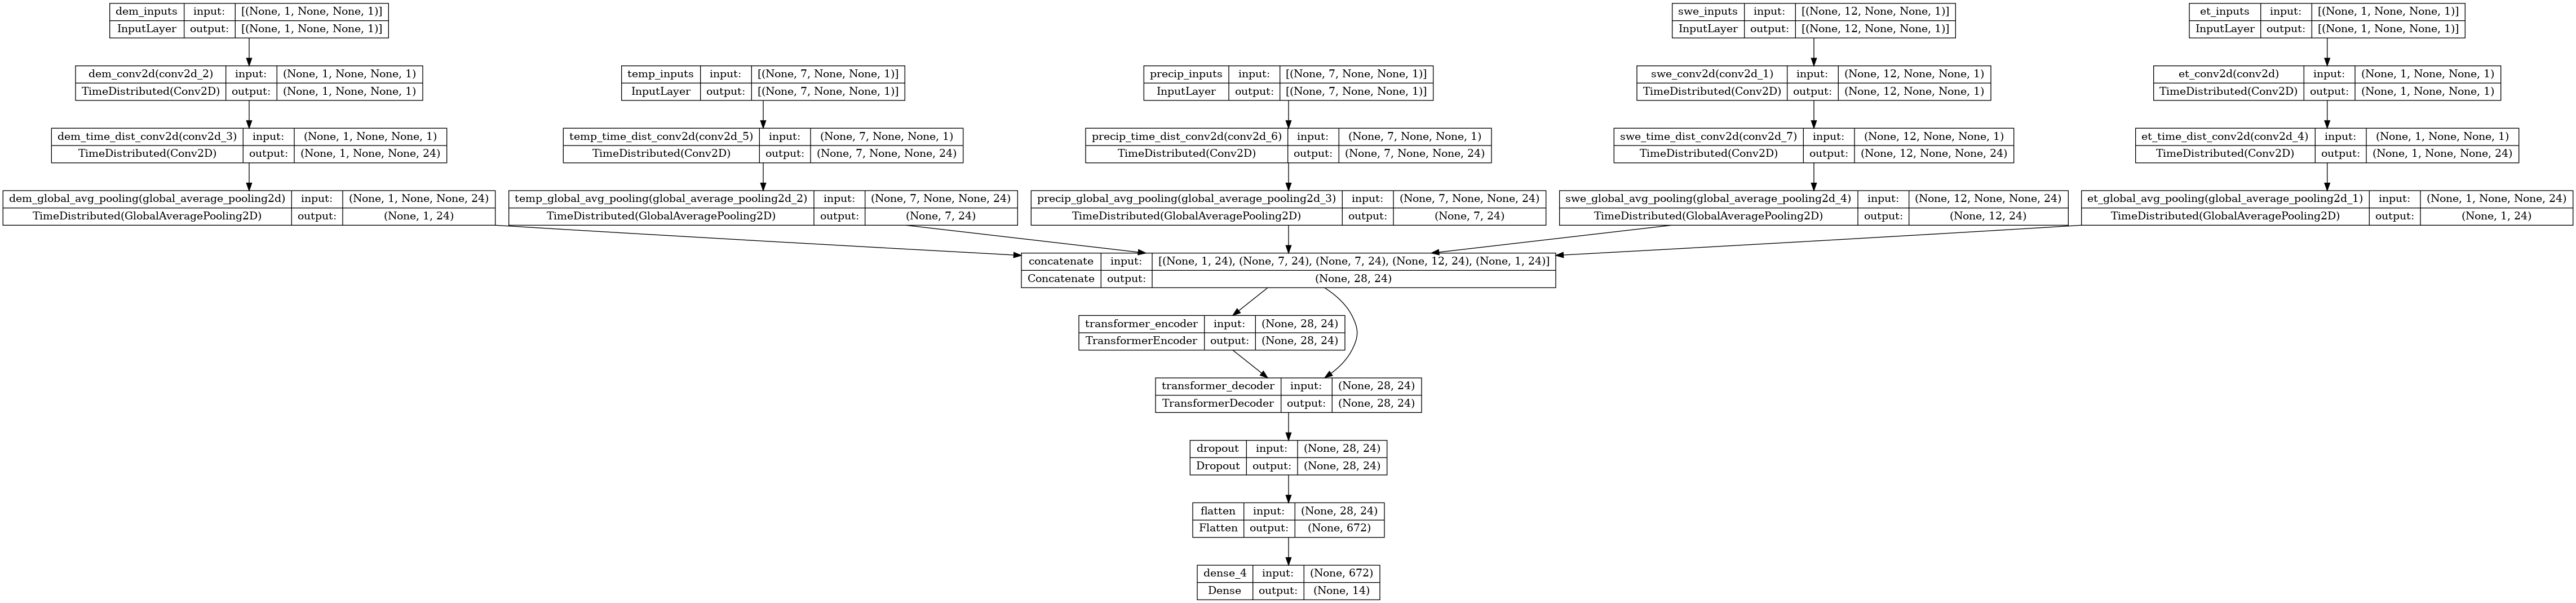

In [5]:
# Run this cell to use the ConvResizeGAPTransArchitecture:

experiment["architecture"] = "ConvResizeGAPTransArchitecture"

def get_conv_resize_model():
    # Create the model architecture:
    architecture = ConvResizeGAPTransArchitecture()
    
    model = architecture.get_model(
        kernal=PARAMETERS["kernal"], strides=PARAMETERS["strides"],
        n_days_precip=PARAMETERS["n_days_precip"], n_days_temp=PARAMETERS["n_days_temp"],
        n_swe=PARAMETERS["n_swe"], n_et=PARAMETERS["n_et"],
        enc_embed_dim=PARAMETERS["enc_embed_dim"], enc_dense_dim=PARAMETERS["enc_dense_dim"],
        enc_num_heads=PARAMETERS["enc_num_heads"],
        dec_embed_dim=PARAMETERS["dec_embed_dim"], dec_dense_dim=PARAMETERS["dec_dense_dim"],
        dec_num_heads=PARAMETERS["dec_num_heads"],
        n_y=PARAMETERS["n_days_y"], hidden_dim=PARAMETERS["hidden_dim"], 
        dropout=PARAMETERS["dropout"], 
        cnn_activation=PARAMETERS["cnn_activation"],
        pooling=PARAMETERS["pooling"],
    )
    return model

model = get_conv_resize_model()
keras.utils.plot_model(model, "conv_resize_model.png", show_shapes=True)

## Create Tensorflow datasets

In [6]:
# Run this cell as is:

def keras_train_gen(debug: bool = False):
    """Construct Keras-compatible train generator."""
    train_data_gen = cnn_data.train_data_generator()
    i = 0
    while True:

        # Generate the training sample dict, making the generator infinite:
        try:
            sample = next(train_data_gen)
        except StopIteration:
            # Reset the generator:
            train_data_gen = cnn_data.train_data_generator()
            i = 0
            sample = next(train_data_gen)

        # Print debug info:
        if debug:
            print(f"Sample {i}, {sample['debug_data']}")

        # Yield data in format required by tensorflow:
        X = [sample[ft] for ft in FEATURES]
        X = tuple([np.expand_dims(np.expand_dims(x, -1), 0) for x in X])
        yield X, np.expand_dims(sample["y"], 0)
        i += 1

def keras_val_gen(debug: bool = False):
    """Construct Keras-compatible validation generator."""
    data_gen = cnn_data.val_data_generator()
    i = 0
    while True:

        # Generate the training sample dict, making the generator infinite:
        try:
            sample = next(data_gen)
        except StopIteration:
            # Reset the generator:
            data_gen = cnn_data.val_data_generator()
            i = 0
            sample = next(data_gen)

        # Print debug info:
        if debug:
            print(f"Sample {i}, {sample['debug_data']}")

        # Yield data in format required by tensorflow:
        X = [sample[ft] for ft in FEATURES]
        X = tuple([np.expand_dims(np.expand_dims(x, -1), 0) for x in X])
        yield X, np.expand_dims(sample["y"], 0)
        i += 1

def keras_test_gen(debug: bool = False):
    """Construct Keras-compatible test generator."""
    data_gen = cnn_data.test_data_generator()
    i = 0
    while True:

        # Generate the training sample dict, making the generator infinite:
        try:
            sample = next(data_gen)
        except StopIteration:
            # Reset the generator:
            data_gen = cnn_data.test_data_generator()
            i = 0
            sample = next(data_gen)

        # Print debug info:
        if debug:
            print(f"Sample {i}, {sample['debug_data']}")

        # Yield data in format required by tensorflow:
        X = [sample[ft] for ft in FEATURES]
        X = tuple([np.expand_dims(np.expand_dims(x, -1), 0) for x in X])
        yield X, np.expand_dims(sample["y"], 0)
        i += 1

output_signature = (
    (  # X-variables:
        tf.TensorSpec(shape=(None, 1, None, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, PARAMETERS["n_days_temp"], None, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, PARAMETERS["n_days_precip"], None, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, PARAMETERS["n_swe"], None, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, PARAMETERS["n_et"], None, None, 1), dtype=tf.float32),
    ),
    # y-variable:
    tf.TensorSpec(shape=(1, PARAMETERS["n_days_y"]), dtype=tf.float32)
)
train_data = tf.data.Dataset.from_generator(keras_train_gen, output_signature=output_signature)
val_data = tf.data.Dataset.from_generator(keras_val_gen, output_signature=output_signature)
test_data = tf.data.Dataset.from_generator(keras_test_gen, output_signature=output_signature)

## Train the model

In [7]:
# Run this cell as is:

experiment["train_start_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=TF_LOG_DIR,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq=PARAMETERS["tf_board_update_freq"],
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)

ckpt_dir = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__ckpts")
if not os.path.exists(ckpt_dir):
    os.mkdir(ckpt_dir)
model_save_callback = tf.keras.callbacks.ModelCheckpoint(
    # f"{ckpt_dir}/model__" + "{epoch:02d}-{val_loss:.2f}.hdf5",
    f"{ckpt_dir}/model__" + "{epoch:02d}-NO_VAL.hdf5",
    monitor = "val_loss",
    verbose = 0,
    save_best_only = False,
    save_weights_only = False,
    mode = "auto",
    save_freq = "epoch",
    options=None,
    initial_value_threshold=None,
)


train_steps_per_epoch = len(cnn_data.train_pairs)
n_val_steps = len(cnn_data.val_pairs)
optimizer = PARAMETERS["opt"](PARAMETERS["learning_rate"])
model.compile(optimizer=optimizer, loss=PARAMETERS["loss"])
model.fit(
    train_data, epochs=PARAMETERS["epochs"], batch_size=1, 
    steps_per_epoch=train_steps_per_epoch,
    # SOMETIMES RAISING WEIRD ERRORS SO JUST SWITCH OFF VALIDATION FOR EXPERIMENTS.
    # The validation results are saved in the cells below anyway.
    # validation_data=val_data, validation_steps=n_val_steps, 
    # validation_batch_size=1, validation_freq=1, 
    callbacks=[tensorboard_callback, model_save_callback]
)
experiment["train_end_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")

Epoch 1/2
3484/3484 [==============================] - 379s 107ms/step - loss: 52.6964
Epoch 2/2
3484/3484 [==============================] - 378s 109ms/step - loss: 39.4071


## Save the experiment results

In [8]:
# Run this cell as is:

# Save the validation predictions:
experiment["val_pred_start_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
val_pred = model.predict(val_data, steps=n_val_steps)
columns = [f"y_day_{y+1}" for y in range(PARAMETERS["n_days_y"])]
df = pd.DataFrame(val_pred, columns=columns)
df["gage"] = [t[0] for t in cnn_data.val_pairs]
df["date"] = [t[1].to_pydatetime().date() for t in cnn_data.val_pairs]
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__val_pred.csv")
order = ["gage", "date"] + columns
df[order].to_csv(fp, encoding="utf-8", index=False)
val_pred = df[order]
experiment["val_pred_end_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")

# Save the test predictions:
experiment["test_pred_start_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
n_test_steps = len(cnn_data.test_pairs)
test_pred = model.predict(test_data, steps=n_test_steps)
columns = [f"y_day_{y+1}" for y in range(PARAMETERS["n_days_y"])]
df = pd.DataFrame(test_pred, columns=columns)
df["gage"] = [t[0] for t in cnn_data.test_pairs]
df["date"] = [t[1].to_pydatetime().date() for t in cnn_data.test_pairs]
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__test_pred.csv")
order = ["gage", "date"] + columns
df[order].to_csv(fp, encoding="utf-8", index=False)
test_pred = df[order]
experiment["test_pred_end_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")

# Save the model JSON:
model_json = model.to_json()
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__model.json")
with open(fp, "w") as f:
    json.dump(model_json, f)

# Save the full trained model:
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__trained_model")
model.save(fp)

# Save the experiment metadata:
experiment["end_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
metadata = {**PARAMETERS, **experiment}
str_metadata = {k: str(v) for k, v in metadata.items()}
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__metadata.yaml")
with open(fp, "w") as f:
    yaml.safe_dump(str_metadata, f)

704/704 [==============================] - 78s 111ms/step


INFO:tensorflow:Assets written to: /tf/toby/discharge-estimation/experiments/d794a258-f6f2-4dbc-a1a8-b726e9047ae7__trained_model/assets


INFO:tensorflow:Assets written to: /tf/toby/discharge-estimation/experiments/d794a258-f6f2-4dbc-a1a8-b726e9047ae7__trained_model/assets


In [9]:
print(f"Finished experiment id = '{experiment_id}'")

Finished experiment id = 'd794a258-f6f2-4dbc-a1a8-b726e9047ae7'
